In [1]:
import os
import numpy as np
import scipy
from scipy.io import wavfile
import scipy.fftpack as fft
from scipy.signal import get_window
import IPython.display as ipd
import matplotlib.pyplot as plt

%matplotlib inline

In [6]:
TRAIN_PATH = '../datasets/ravdess/'
ipd.Audio(rate=48000, filename=TRAIN_PATH + "03-02-01-01-01-01-01.wav")

In [234]:
sample_rate, audio = wavfile.read(TRAIN_PATH + "03-02-05-02-02-02-01.wav")
print("Sample rate: {0}Hz".format(sample_rate))
print("Audio duration: {0}s".format(audio))

Sample rate: 48000Hz
Audio duration: [15 13  7 ...  0  0  0]s


/tmp/ipykernel_9075/3508884650.py:1: WavFileWarning: Chunk (non-data) not understood, skipping it.
  sample_rate, audio = wavfile.read(TRAIN_PATH + "03-02-05-02-02-02-01.wav")


In [235]:
audio[:100]

array([ 15,  13,   7,   0,  -4,  -1,   0,   3,  10,  24,  40,  40,  23,
        -3, -23, -28, -21, -11,  -2,   6,  15,  21,  22,  17,  13,  16,
        24,  27,  22,  18,  21,  20,  11,  -3, -14, -14, -12, -14, -19,
       -27, -38, -52, -55, -42, -17,   1,  14,  23,  26,  15,   2,  -2,
        -4,  -3,  -5, -12, -20, -25, -28, -26, -23, -18,  -7,   0,   1,
        -7, -18, -29, -35, -38, -34, -24, -18, -20, -21, -15,  -9,  -1,
         3,  10,   9,   3,   1,   5,  13,  21,  30,  34,  27,  10,   2,
         1,   0,  -8, -12,  -5,   0,   0,  -6, -15], dtype=int16)

In [236]:
def normalize_audio(audio):
    audio = audio / np.max(np.abs(audio))
    return audio

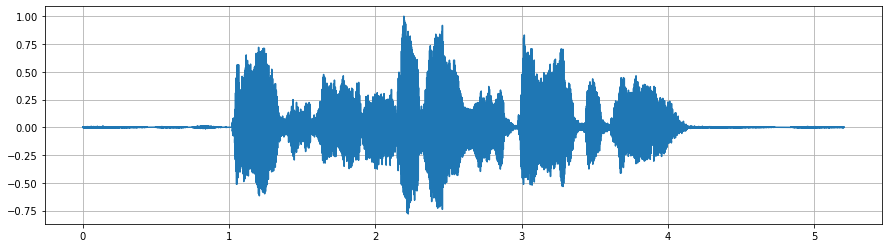

In [237]:
audio = normalize_audio(audio)
plt.figure(figsize=(15,4))
plt.plot(np.linspace(0, len(audio) / sample_rate, num=len(audio)), audio)
plt.grid(True)

In [238]:
def frame_audio(audio, FFT_size=2048, hop_size=10, sample_rate=44100):
    # hop_size in ms
    
    audio = np.pad(audio, int(FFT_size / 2), mode='reflect')
    frame_len = np.round(sample_rate * hop_size / 1000).astype(int)
    frame_num = int((len(audio) - FFT_size) / frame_len) + 1
    frames = np.zeros((frame_num,FFT_size))
    
    for n in range(frame_num):
        frames[n] = audio[n*frame_len:n*frame_len+FFT_size]
    
    return frames

In [252]:
hop_size = 15 #ms
FFT_size = 2048

audio_framed = frame_audio(audio, FFT_size=FFT_size, hop_size=hop_size, sample_rate=sample_rate)
print("Framed audio shape: {0}".format(audio_framed.shape))

Framed audio shape: (348, 2048)


In [240]:
print("First frame:")
audio_framed[1]

First frame:


array([-0.00093514, -0.00033398, -0.00026718, ..., -0.00340659,
       -0.00300581, -0.00213747])

In [241]:
print("Last frame:")
audio_framed[-1]

Last frame:


array([6.67958052e-05, 5.34366442e-04, 1.00193708e-03, ...,
       1.33591610e-03, 1.40271191e-03, 1.46950771e-03])

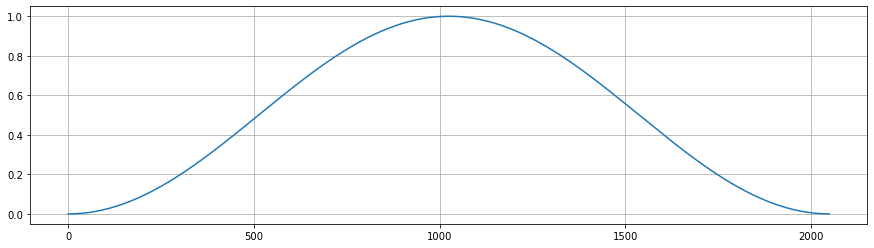

In [242]:
window = get_window("hann", FFT_size, fftbins=True)
plt.figure(figsize=(15,4))
plt.plot(window)
plt.grid(True)

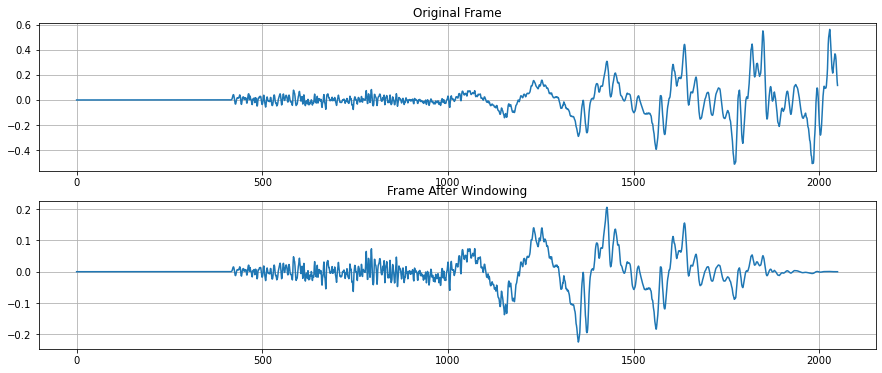

In [243]:
audio_win = audio_framed * window

ind = 69
plt.figure(figsize=(15,6))
plt.subplot(2, 1, 1)
plt.plot(audio_framed[ind])
plt.title('Original Frame')
plt.grid(True)
plt.subplot(2, 1, 2)
plt.plot(audio_win[ind])
plt.title('Frame After Windowing')
plt.grid(True)

In [244]:
audio_winT = np.transpose(audio_win)

audio_fft = np.empty((int(1 + FFT_size // 2), audio_winT.shape[1]), dtype=np.complex64, order='F')

for n in range(audio_fft.shape[1]):
    audio_fft[:, n] = fft.fft(audio_winT[:, n], axis=0)[:audio_fft.shape[0]]

audio_fft = np.transpose(audio_fft)

In [245]:
audio_power = np.square(np.abs(audio_fft))
print(audio_power.shape)

(348, 1026)


In [246]:
freq_min = 0
freq_high = sample_rate / 2
mel_filter_num = 10

print("Minimum frequency: {0}".format(freq_min))
print("Maximum frequency: {0}".format(freq_high))

Minimum frequency: 0
Maximum frequency: 24000.0


In [247]:
def freq_to_mel(freq):
    return 2595.0 * np.log10(1.0 + freq / 700.0)

def met_to_freq(mels):
    return 700.0 * (10.0**(mels / 2595.0) - 1.0)

In [248]:
def get_filter_points(fmin, fmax, mel_filter_num, FFT_size, sample_rate=44100):
    fmin_mel = freq_to_mel(fmin)
    fmax_mel = freq_to_mel(fmax)
    
    print("MEL min: {0}".format(fmin_mel))
    print("MEL max: {0}".format(fmax_mel))
    
    mels = np.linspace(fmin_mel, fmax_mel, num=mel_filter_num+2)
    freqs = met_to_freq(mels)
    
    return np.floor((FFT_size + 1) / sample_rate * freqs).astype(int), freqs

In [253]:
filter_points, mel_freqs = get_filter_points(freq_min, freq_high, mel_filter_num, FFT_size, sample_rate=44100)
print(filter_points.shape)
print(mel_freqs.shape)

MEL min: 0.0
MEL max: 4016.019179871836
(12,)
(12,)


In [250]:
def get_filters(filter_points, FFT_size):
    filters = np.zeros((len(filter_points)-2,int((FFT_size/2)+1)))
    print(filters.shape)
    for n in range(len(filter_points)-2):
        filters[n, filter_points[n] : filter_points[n + 1]] = np.linspace(0, 1, filter_points[n + 1] - filter_points[n])
        filters[n, filter_points[n + 1] : filter_points[n + 2]] = np.linspace(1, 0, filter_points[n + 2] - filter_points[n + 1])
    
    return filters

In [254]:
filters = get_filters(filter_points, FFT_size)
# print(filters)
plt.figure(figsize=(15,4))
for n in range(filters.shape[0]):
    plt.plot(filters[n])

(10, 1025)


ValueError: could not broadcast input array from shape (318,) into shape (228,)

In [ ]:
# taken from the librosa library
enorm = 2.0 / (mel_freqs[2:mel_filter_num+2] - mel_freqs[:mel_filter_num])
filters *= enorm[:, np.newaxis]

In [ ]:
plt.figure(figsize=(15,4))
for n in range(filters.shape[0]):
    plt.plot(filters[n])

In [ ]:
print(audio_power.shape, filters.shape)
audio_filtered = np.dot(filters, np.transpose(audio_power))
audio_log = 10.0 * np.log10(audio_filtered)
audio_log.shape

In [ ]:
def dct(dct_filter_num, filter_len):
    basis = np.empty((dct_filter_num,filter_len))
    basis[0, :] = 1.0 / np.sqrt(filter_len)
    
    samples = np.arange(1, 2 * filter_len, 2) * np.pi / (2.0 * filter_len)

    for i in range(1, dct_filter_num):
        basis[i, :] = np.cos(i * samples) * np.sqrt(2.0 / filter_len)
        
    return basis

In [ ]:
dct_filter_num = 40

dct_filters = dct(dct_filter_num, mel_filter_num)

cepstral_coefficents = np.dot(dct_filters, audio_log)
cepstral_coefficents.shape

In [ ]:
cepstral_coefficents[:, 0]

In [ ]:
plt.figure(figsize=(15,5))
plt.plot(np.linspace(0, len(audio) / sample_rate, num=len(audio)), audio)
plt.imshow(cepstral_coefficents, aspect='auto', origin='lower');